This notebook demonstrates the functions of the used modeling framework, and also how it reproduces some well known phenomenon of Gq coupled G-Protein Coupled receptor signaling. The main functions of the model are in model_vectorised.py.. 

In [1]:
%matplotlib inline
### loading necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from model_vectorised import *
mpl.rcParams['figure.figsize'] = (10,10)
sns.set_style('whitegrid')

The main class we will use is VecModel(*dt*), where *dt* is the time (s) between two integration step (float). We can read the data for our model from any text file with read(*fname*) method. The model text file has the following structure:
1. lines with # are not readed in (you can comment with it) 
2. after #molecules the molecules of the model are coming
3. for each molecule one line *a*, *b*, *c* comes, where *a* is the index of the molecule (increasing integers starting with 1); *b* is 1 when the concentraion of the molecule is consant, 0 otherwise; and *c* is the initial concentration.
4. after #reactions the reactions of the model are coming
5. for each reaction one line *a*, *b*, *c*, *d* comes, where *a* is the index of the reacion (increasing integers starting with 1); *b* is the indexes of the molecules on the left side of the reaction, separated by spaces; *c* is the indexes of the molecules on the right side of the reaction, separated by spaces; and *d* is the reaction constant of the reaction. Eg.: 1,1 2,3 4,0.5 means the 1st reacion of a model, where 1+2->3+4 with reaction constant 0.5 (where 1, 2, 3, 4 are previously defined molecules).
6. the model file finishes wih #end
7. do not leave empty lines


You can simulate the model with model.simulate(*time in seconds*).

In [2]:
model=VecModel(0.1) #dt=0.1
model.read('../models/toth_szalai_modified2.txt')
model.simulate(600) #simulate for 600 s

With model.plot(*molecules*) you can plot the molecules in list *molecules*. In list *molecules* you have to keep the indexes of the molecules you want to plot.

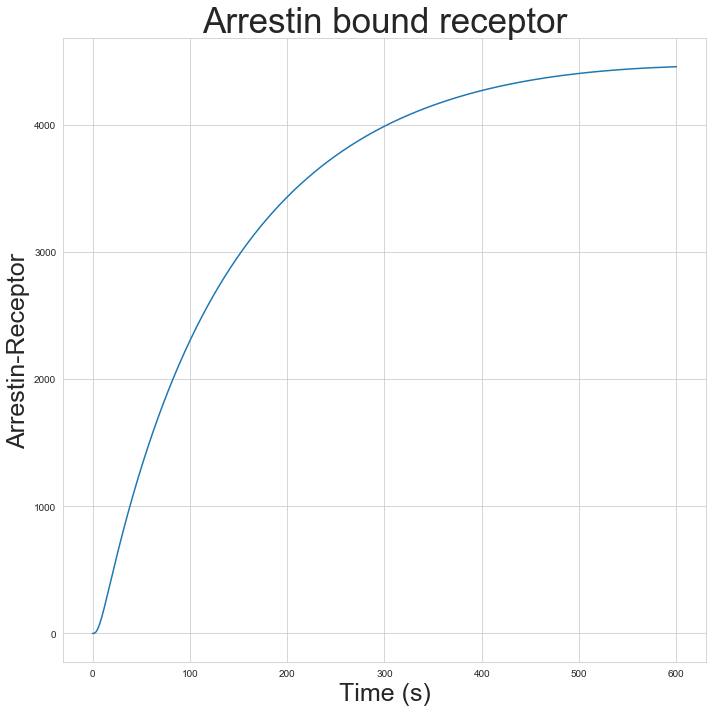

In [3]:
molecules_dict={'Arrestin-Receptor':[10,11,12,13,14,15]} #arrestin bound receptor, from Figure 1
plt.figure(1)
model.plot(molecules_dict['Arrestin-Receptor'])
plt.xlabel('Time (s)',size=25)
plt.ylabel('Arrestin-Receptor',size=25)
plt.title('Arrestin bound receptor',size=35)
plt.tight_layout()

With model.change_ccs(*molecules*, *value(s)*) you can change the concentration / abundance of the molecules in list *molecules*. If *value* is an integer, all the molecules in *molecules* will get this value. Let's make a dose response experiment with increasing ligand concentrations:

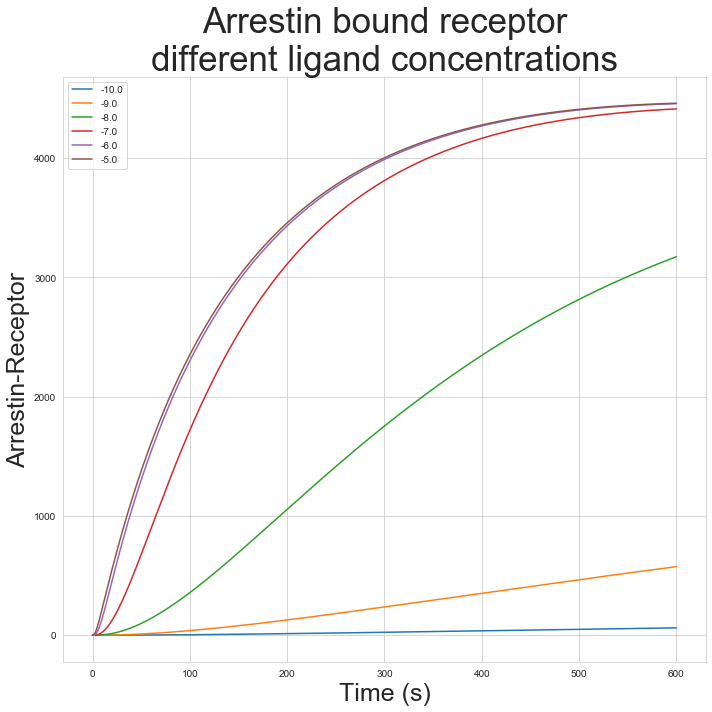

In [5]:
molecules_dict['Ligand']=[1,3] #ligand cc in uM, from Figure 1
ligands=10**np.arange(-4,1.5,1) #from 100 pM to 10 uM
for ligand in ligands:
    model=VecModel(0.1)
    model.read('../models/toth_szalai_modified2.txt')
    model.change_ccs(molecules_dict['Ligand'],ligand)
    model.simulate(600)
    model.plot(molecules_dict['Arrestin-Receptor'])
plt.legend(np.log10(ligands)-6) #concentration in M 
plt.xlabel('Time (s)',size=25)
plt.ylabel('Arrestin-Receptor',size=25)
plt.title('Arrestin bound receptor\ndifferent ligand concentrations',size=35)
plt.tight_layout()

Before going further, let's check that our model is stable, or not (i.e. when ligand concentraion is 0, molecule concenrations should remain constant).

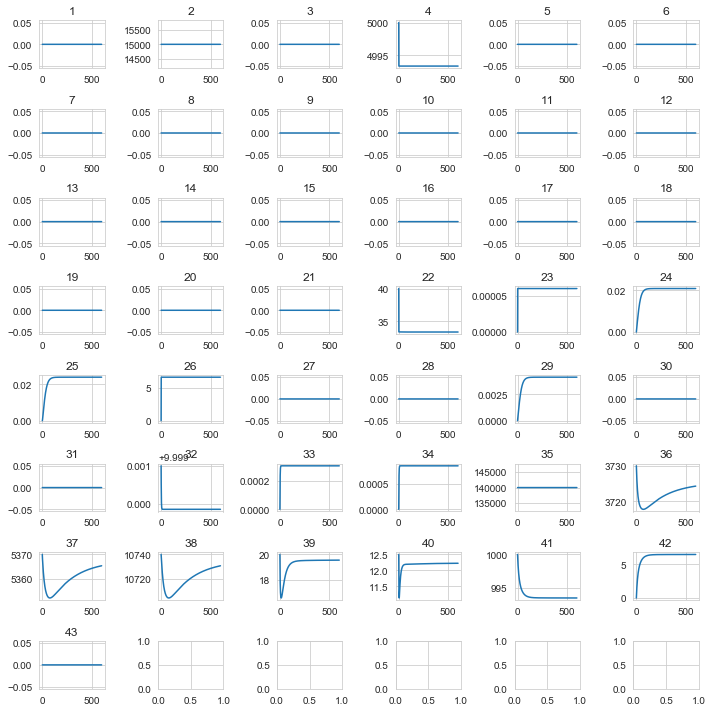

In [7]:
model=VecModel(0.1)
model.read('../models/toth_szalai_modified2.txt')
model.change_ccs(molecules_dict['Ligand'],0)
f,axs=plt.subplots(8,6) #we have 44 molecules, so they will fit in 8*6=48 subplots
model.simulate(600)
for i in range(1,44):
    r=(i-1)//6
    c=(i-1)%6
    model.plot([i],axs[r,c]) #if you give an axis object to model.plot(), it will plot there
    axs[r,c].set_title(str(i))
plt.tight_layout()    

You can see that all of the molecules reach very fast a constant level, close to the initial value.

In the following simulations, we will have 3 types of cellular models.
1. Arrestin and recepor overexpressing cells (this is the original model setting). It resembles a typical experimental situation, where the interaction between these proteins is measured (e.g.: resonance energy transfer).
2. IP3 sensor and receptor overexpressing cells. In this setting the arrestin initail concetration is decreased to 1000 (from 15000) and sensor molecule concentration is increased to 6000 (from 0). This resembles a typical experimental situation, where the we measure the second messenger (IP3) concentration with some sensor.
3. Physiological system. In this setting the arrestin initail concetration is decreased to 1000 (from 15000) and receptor initial concentration is decreased to 50 (from 5000).

Let's see how these models behave in terms of receptor - arrestin binding and second messenger generation.

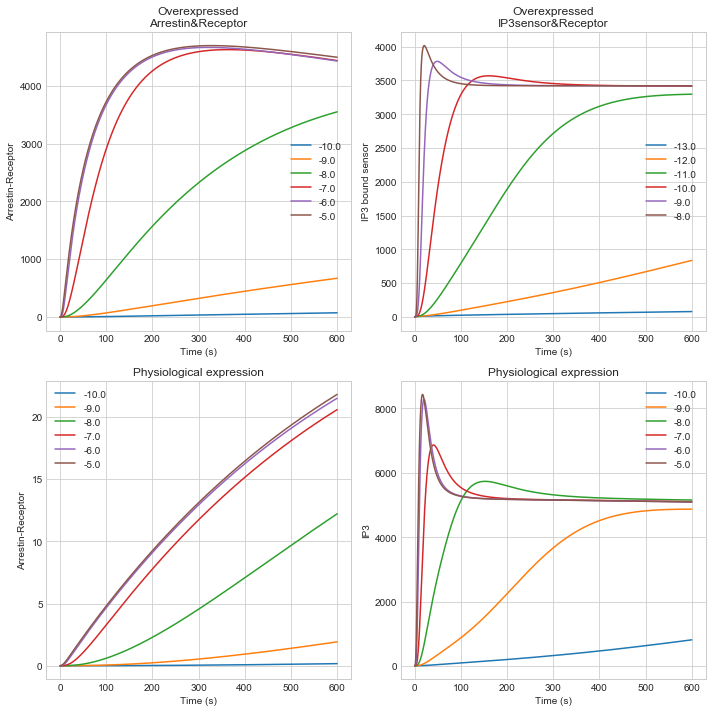

In [15]:
molecules_dict['Arrestin']=[2]
molecules_dict['Receptor']=[4]
molecules_dict['Sensor']=[44]
molecules_dict['SensorIP3']=[45]
molecules_dict['IP3']=[40]
f,axs=plt.subplots(2,2)

#simulation for 1.
ligands=10**np.arange(-4,1.5,1) #from 100 pM to 10 uM
for ligand in ligands:
    model=VecModel(0.1)
    model.read('../models/toth_szalai_modified2.txt')
    model.change_ccs(molecules_dict['Ligand'],ligand)
    model.simulate(600)
    model.plot(molecules_dict['Arrestin-Receptor'],axs[0,0])
axs[0,0].legend(np.log10(ligands)-6)
axs[0,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('Arrestin-Receptor')
axs[0,0].set_title('Overexpressed\nArrestin&Receptor')

#simulation for 2.
if False:
    ligands=10**np.arange(-7,-1.5,1) #from 100 fM to 10 nM
    for ligand in ligands:
        model=VecModel(0.1)
        model.read('../models/toth_szalai_final.txt')
        model.change_ccs(molecules_dict['Ligand'],ligand)
        model.change_ccs(molecules_dict['Arrestin'],1000)
        model.change_ccs(molecules_dict['Sensor'],6000)
        model.simulate(600)
        model.plot(molecules_dict['SensorIP3'],axs[0,1])
    axs[0,1].legend(np.log10(ligands)-6)
    axs[0,1].set_xlabel('Time (s)')
    axs[0,1].set_ylabel('IP3 bound sensor')
    axs[0,1].set_title('Overexpressed\nIP3sensor&Receptor')

#simulation for 3.
ligands=10**np.arange(-4,1.5,1) #from 100 pM to 10 uM
for ligand in ligands:
    model=VecModel(0.1)
    model.read('../models/toth_szalai_final.txt')
    model.change_ccs(molecules_dict['Ligand'],ligand)
    model.change_ccs(molecules_dict['Arrestin'],1000)
    model.change_ccs(molecules_dict['Receptor'],50)
    model.simulate(600)
    model.plot(molecules_dict['Arrestin-Receptor'],axs[1,0])
    model.plot(molecules_dict['IP3'],axs[1,1])
axs[1,0].legend(np.log10(ligands)-6)
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Arrestin-Receptor')
axs[1,0].set_title('Physiological expression')
axs[1,1].legend(np.log10(ligands)-6)
axs[1,1].set_xlabel('Time (s)')
axs[1,1].set_ylabel('IP3')
axs[1,1].set_title('Physiological expression')
plt.tight_layout()

You can see that while "qualitatively" overexpression and physiological systems are similar, there are important differences. In both case arrestin binding is shifted right compared to the IP3 response. This is mainly the consequence of the fact that arrestin - receptor interaction is 1:1, while there is an amplification step between recptor and second messenger generation. In case of the physiological system, IP3 dose-response is less left shifted than in the overexpression system. The reasons for this is the lower number of (spare) receptors, and also the sensitiviy of the IP3 sensor. Also an important differnce is the slower kinetic of arrestin binding in the physiological system.

Finally, let's check the main finding of our manuscript: increasing the dissociation constant of the receptor - ligand binding interaction leads to decreased arrestin binding (Emax) but leaves IP3 signaling intact. For this we can use the model.change_constat(constants,values) function, which is similar to the model.change_ccs() function. Let's check this phenomenon in the physiological setting.

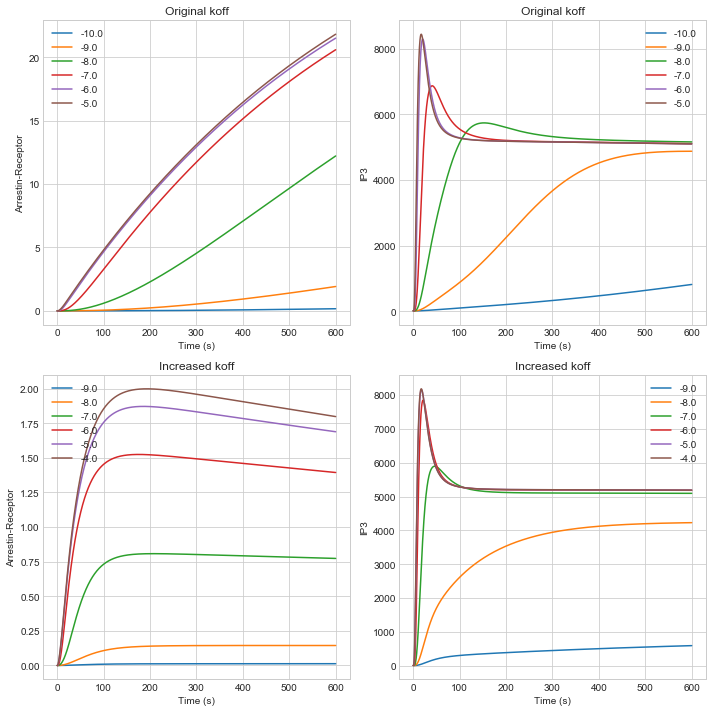

In [16]:
constant_dict={}
constant_dict['Receptor-Ligand koff']=[2,4,6,8,10,12,14,16,18,20,22,24,45,47,49,51]
f,axs=plt.subplots(2,2)
ligands=10**np.arange(-4,1.5,1) #from 100 pM to 10 uM
for ligand in ligands:
    model=VecModel(0.1)
    model.read('../models/toth_szalai_final.txt')
    model.change_ccs(molecules_dict['Ligand'],ligand)
    model.change_ccs(molecules_dict['Arrestin'],1000)
    model.change_ccs(molecules_dict['Receptor'],50)
    model.simulate(600)
    model.plot(molecules_dict['Arrestin-Receptor'],axs[0,0])
    model.plot(molecules_dict['IP3'],axs[0,1])
axs[0,0].legend(np.log10(ligands)-6)
axs[0,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('Arrestin-Receptor')
axs[0,0].set_title('Original koff')
axs[0,1].legend(np.log10(ligands)-6)
axs[0,1].set_xlabel('Time (s)')
axs[0,1].set_ylabel('IP3')
axs[0,1].set_title('Original koff')
ligands=10**np.arange(-3,2.5,1) #we use larger concentrations, as Kd is larger
for ligand in ligands:
    model=VecModel(0.1)
    model.read('../models/toth_szalai_final.txt')
    model.change_ccs(molecules_dict['Ligand'],ligand)
    model.change_ccs(molecules_dict['Arrestin'],1000)
    model.change_ccs(molecules_dict['Receptor'],50)
    model.change_constant(constant_dict['Receptor-Ligand koff'],0.03)
    model.simulate(600)
    model.plot(molecules_dict['Arrestin-Receptor'],axs[1,0])
    model.plot(molecules_dict['IP3'],axs[1,1])
axs[1,0].legend(np.log10(ligands)-6)
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Arrestin-Receptor')
axs[1,0].set_title('Increased koff')
axs[1,1].legend(np.log10(ligands)-6)
axs[1,1].set_xlabel('Time (s)')
axs[1,1].set_ylabel('IP3')
axs[1,1].set_title('Increased koff')
plt.tight_layout()

You can see that while in the IP3 signaling no big difference can be observed (of course we have a right shift of the DR curve based on the increased koff/Kd), in case of arrestin binding there is a large decrease of maximal binding. 